### Implementazione di TabNet, confrontato con gli altri Algoritmi di Apprendimento (Come XGBoost) per vedere qual'e' il migliore applicato al dataset paysim

## Content
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

Headers
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer #Sostituisci i valori mancanti utilizzando una statistica descrittiva (ad es. media, mediana o più frequente) lungo ogni colonna o utilizzando un valore costante.
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import  cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

In [18]:
#torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
df = pd.read_csv('utils/paysim1.csv')

df.head()

In [4]:
#df = df.head(1000000)
#df.info()

---------------------------------Fraud Transactions---------------------------------
0    6362604
1         16
Name: isFlaggedFraud, dtype: int64


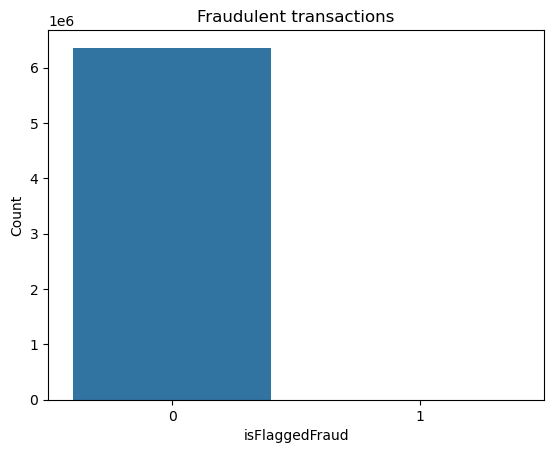

In [3]:
print("---------------------------------Fraud Transactions---------------------------------")
print(df.isFlaggedFraud.value_counts())
sns.countplot(x='isFlaggedFraud', data=df)
plt.ylabel('Count')
plt.title('Fraudulent transactions')
plt.show()

#Solo 16 trasazioni risultano essere fraudolente

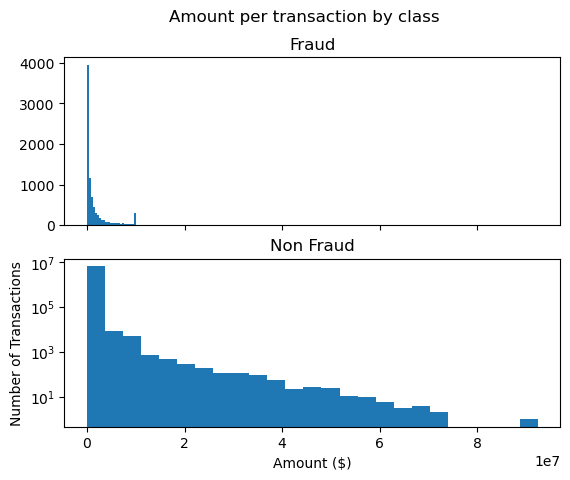

In [4]:
fraud = df[df['isFraud']==1]
normal = df[df['isFraud']==0]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 25
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins = bins)
ax2.set_title('Non Fraud')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
# plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

In [5]:
#Featute Preprocessing
data = df.copy()

#Se trova qualcuno che ha come origine C, allora setta 1, 0 altrimenti
data['OrigC']=data['nameOrig'].apply(lambda x: 1 if str(x).find('C') == 0 else 0)
data['DestC']=data['nameDest'].apply(lambda x: 1 if str(x).find('C') == 0 else 0)

data['TRANSFER']= data['type'].apply(lambda x: 1 if x == 'TRANSFER' else 0)
data['CASH_OUT']= data['type'].apply(lambda x: 1 if x == 'CASH_OUT' else 0)

In [6]:
data['OrigAmntErr']=(abs(data.oldbalanceOrg-data.newbalanceOrig)-data.amount)

In [7]:
drop_columns = ['isFlaggedFraud', 'type', 'nameDest', 'nameOrig']

### Compute the Model

In [8]:
#print result
def model_result(clf,x_test,y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)
    print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print('F1 - score :',(f1_score(y_test,y_pred)))
    print('Confusion_matrix : ')
    print(confusion_matrix(y_test,y_pred))
    print("accuracy_score")
    print(accuracy_score(y_test,y_pred))
    print("classification_report")
    print(classification_report(y_test,y_pred))

In [9]:
#Inizio a splittare i dati 
new_data = data.drop(labels=drop_columns, axis=1)
X = new_data.drop('isFraud', axis=1)
y = data.isFraud

In [10]:
#splitto il dataset
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42, shuffle=False)

print("Shape X_test: ", X_test.shape)
print("Shape X_train: ", X_train.shape)
print("Shape y_test", y_test.shape)
print("Shape y_train", y_train.shape)

Shape X_test:  (1272524, 11)
Shape X_train:  (5090096, 11)
Shape y_test (1272524,)
Shape y_train (5090096,)


In [14]:
%%time

#Metto i vari classificatori cosi da confrontarli 
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
#y_pred = random_forest.predict(X_test)

print("---------------------------------------Random Forest-----------------------------------------------")
model_result(random_forest, X_test, y_test)

---------------------------------------Random Forest-----------------------------------------------
AUPRC : 1.0
F1 - score : 0.999764871855161
Confusion_matrix : 
[[1268270       0]
 [      2    4252]]
accuracy_score
0.9999984283204089
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1268270
           1       1.00      1.00      1.00      4254

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

CPU times: total: 16min 57s
Wall time: 27min 34s


In [ ]:
%%time

#XGBoost con i pesi
print("---------------------------------------XGB-------------------------------------------------")
weight = (y == 0).sum() / (1.0 * (y == 1).sum()) #pesi per il target
xgb_classifier = XGBClassifier(scale_pos_wight=weight, n_jobs=4, random_state=42) 
xgb_classifier.fit(X_train, y_train)
#y_pred_xgb = xgb_classifier.predict(X_test)
model_result(xgb_classifier, X_test, y_test)

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import KFold

tab_clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-3),
                       scheduler_params={"step_size":10, "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                        )
        
tab_clf.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               eval_name=['train', 'valid'],
               eval_metric=['accuracy'],
               max_epochs=1000 , patience=100,
               batch_size=28, drop_last=False)

    #cv_score.append(tab_clf.best_cost)
    #prediction_array.append(np.expm1(tab_clf.predict(X_test)))

print("----------------------------TabNet--------------------------------")
model_result(tab_clf, X_test, y_test)        